# Интеллектуальный анализ данных – весна 2022

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [260]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

Оставлю один рисуночек из эмозди как дань уважения

In [261]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————

Пусть классам $k_1\ и\ k_2$  соответствуют целевые переменные 0 и 1 соответственно

In [262]:
arr = np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 1])

В случае классификации работаем с вероятностями (частотами встречаемости классов). Они будут высчитываться в каждой функции и записываться в переменную `probs`

In [263]:
def entropy(probs: np.ndarray) -> float:
    probs = np.unique(arr, return_counts=True)[1] / arr.shape[0]

    return -probs @ np.log(probs)

print('Entropy =', round(entropy(arr), 2))

Entropy = 0.5


Если так подумать, то формулы можно представить в виде скалярного произведения, да и выглядит красивее (по производительности хз если честно)

**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [264]:
def gini(arr: np.ndarray) -> float:
    probs = np.unique(arr, return_counts=True)[1] / arr.shape[0]

    return probs @ (1 - probs)


print('Gini coeff =', gini(arr))

Gini coeff = 0.32


Значение совпадает с эталонным ($0.2 \cdot 0.8 + 0.8 \cdot 0.2$ = 0.32)

Теперь посчитаем критерий информативности

In [265]:
gini(arr) - 2/10 * gini(np.ones((2,))) - 8/10 * gini(np.zeros((8,)))

0.32

Видим, что значение критерия информативности совпадает с хаотичностью изначальной вершины. Так и должно быть, потому что имеем идеальное разделение, при котором в листе находятся объекты только одного класса. А хаотичность каждого такого листа равна 0

**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

Если честно, так и не понял что такое предсказание модели в данном случае. У нас же нет ни разбиения, ни модели как таковой. Поэтому просто посчитал хаотичность вершины через дисперсию

In [266]:
def variance(nums: np.ndarray) -> float:
    return np.mean(np.square(nums - nums.mean()))

print('Variance =', round(variance(np.array([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])), 2))

Variance = 1035.24


## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [267]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

---

На эту функцию я потратил оооч много времени. Хз почему за нее дается так мало баллов, так как это вообще одна из самых сложных частей в домашке. Ну либо я дурачок и можно было как-то супер просто сделать

Все сделал без циклов, но с векторизованными функциями. Разберемся с каждой поподробнее

Функция `Q_real` считает критерий информативности, если признак - вещественный
- `t_ind` - индекс порога
- `Rm_sorted`- отсортированный по возрастанию вектор значений признака

Так как подаем на вход отсортированные по признаку значения целевой переменной, можно передавать только номер порога (фактически число элементов в левой вершине). Альтернативный вариант - передавать порог, дальше смотреть на индексы всех значений, для которых признак меньше/больше порога и считать хаотичности. Но это бессмысленно, так как быстрее использовать уже отсортированный массив (отсортирован он в функции `find_best_split` чтобы найти все возможные пороги)

Функция `Q_cat` считает критерий информативности, если признак - категориальный
- `cl` - класс, относительно которого выполняем разбиение
- `feature_vector` - вектор со значениями признака
- `Rm` - вектор со значениями целевой переменной

Мы ищем индексы элементов, принадлежащих рассматриваемому классу, далее смотрим на хаотичность целевой переменной в левой и правой вершинах


Общие параметры
- `HR_m` - заранее подсчитанная хаотичность вершины (чтобы не считать заново при каждом разбиении)
- `impurity_func` - функция хаотичности (в засимости от задания)

In [268]:
from typing import Callable

def Q_real(t_ind: int, Rm_sorted: np.ndarray, HR_m: float, impurity_func: Callable):
    HR_l = impurity_func(Rm_sorted[:t_ind])
    HR_r = impurity_func(Rm_sorted[t_ind:])

    n = Rm_sorted.shape[0]

    return HR_m - t_ind * HR_l / n - (n - t_ind) * HR_r / n


Q_real_vec = np.vectorize(Q_real, excluded=['Rm_sorted'])

In [269]:
def Q_cat(cl: int,
          feature_vector: np.ndarray,
          Rm: np.ndarray,
          HR_m: float,
          impurity_func: Callable):
    
    this_cls = feature_vector == cl
    l = this_cls.sum() # Число True, т.е. сумма булевого массива
    n = Rm.shape[0]

    HR_l = impurity_func(Rm[this_cls])
    HR_r = impurity_func(Rm[~this_cls])

    return HR_m - l * HR_l / n - (n - l) * HR_r / n

Q_cat_vec = np.vectorize(Q_cat, excluded=['feature_vector', 'Rm'])

In [270]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов, len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """

    impurity = np.var if task == 'regression' else gini
    HR_m = impurity(target_vector)
    feature_vector = np.array(feature_vector)
    target_vector = np.array(target_vector)

    if feature_type == 'real':

        sorted_ind = feature_vector.argsort()
        sorted_features = feature_vector[sorted_ind]
        sorted_target = target_vector[sorted_ind]

        thresholds = (sorted_features[:-1] + sorted_features[1:]) / 2

        Qs = Q_real_vec(np.arange(1, feature_vector.shape[0]), 
                   Rm_sorted=sorted_target, 
                   HR_m=HR_m, 
                   impurity_func=impurity)

    elif feature_type == 'categorical':
        
        thresholds = np.unique(feature_vector)
        
        Qs = Q_cat_vec(thresholds,
                        feature_vector=feature_vector,
                        Rm=target_vector,
                        HR_m=HR_m, 
                        impurity_func=impurity)
            
    else:
        raise TypeError('Feature type is incorrect')
    

    best_ind = np.argmax(Qs, axis=0)
    best_Q = Qs[best_ind]
    best_threshold = thresholds[best_ind]
            
    return thresholds, Qs, best_threshold, best_Q

В случае с категориальными признаками все вроде понятно

Когда признак - вещественный, мы должны получить все возможные пороги. То есть отсортировать массив значений признака и посчитать среднее между всеми соседними. Автоматом еще получили отсортированный по признаку вектор целевой переменной (так как `feature_vector` мапится в `target_vector`)

Кастовал векторы в массивы numpy, так как без этого не работает трюк с `thresholds` (ну прикольно же, да?). Если использовать `pd.Series`, то вектора будут суммироваться склеиваясь по индексам, и там получается супер бред

Эту функцию можно протестировать на датасете `California`.

In [271]:
from sklearn.datasets import fetch_california_housing

In [272]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [273]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

In [274]:
thresholds, Qs, thr_best, Q_best = find_best_split(X['MedInc'], y, task='regression', feature_type='real')

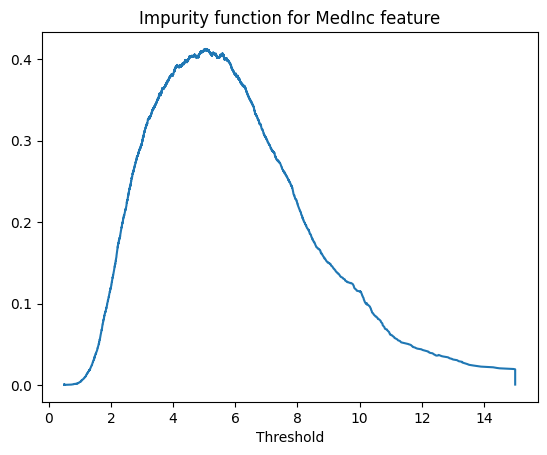

In [275]:
plt.title('Impurity function for MedInc feature')
plt.xlabel('Threshold')

plt.plot(thresholds, Qs)
plt.show()

Отчетливо видим скачок критерия информативности при определенном пороге. Для плохих разбиений, где число элементов в одном из листов мало - критерий информативности улетает в 0

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [276]:
print(thr_best)

5.03515


По графику видно, что так оно и есть

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [277]:
class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task
        
        # Переменная, если вы решите делать бонус
        self._feature_importances = {}
        

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        
        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector < threshold_best

                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = feature_vector == threshold_best
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node['type'] == 'terminal':
            return node['class']
        feature = node['feature_split']

        if self._feature_types[feature] == "real":
            positive = x[feature] < node['threshold']
        elif self._feature_types[feature] == "categorical":
            positive = x[feature] == node['category_split']
        else:
            raise ValueError('Wrong feature type')

        return self._predict_node(x, node['left_child' if positive else 'right_child'])


    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

Ммммм, легаси код, аооаоа. Но вроде даже разобрался и что-то да работает

Но не понятно только где юзаются гиперпараметры для дерева. Засунуть их в код вроде не просили, но по хорошему надо бы

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [278]:
data = pd.read_csv('students.csv', index_col=0)
data.head()

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0


In [279]:
features =  data.columns[:-1]

res = {f: find_best_split(data[f], data['UNS'], task='classification', feature_type='real') for f in features}

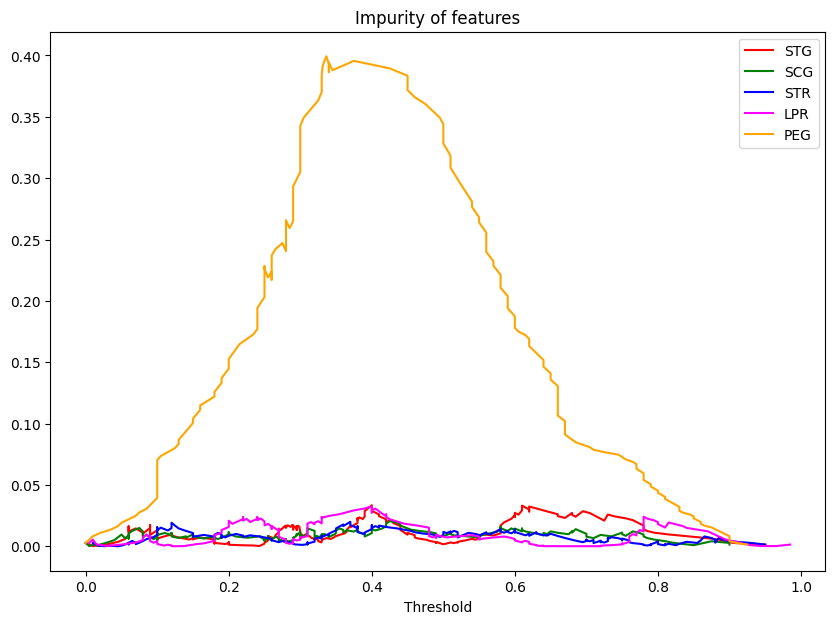

In [280]:
plt.figure(figsize=(10, 7))
plt.title('Impurity of features')

colors = ['red', 'green', 'blue', 'magenta', 'orange']


for i, color, feature in zip(range(5), colors, features):
    plt.plot(res[feature][0], res[feature][1], color=color, label=feature)

plt.xlabel('Threshold')
plt.legend()
plt.show()

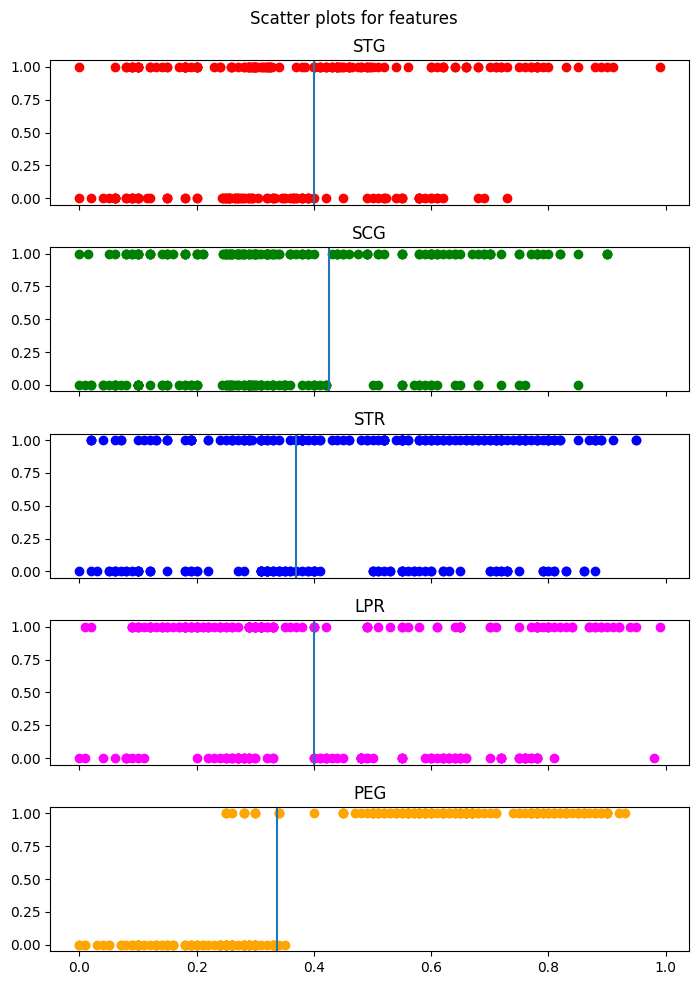

In [281]:
fig, axs = plt.subplots(5, 1, figsize=(7, 10), sharex=True)
fig.suptitle('Scatter plots for features')

for i, color, feature in zip(range(5), colors, features):
    axs[i].set_title(feature)
    axs[i].scatter(data[feature], data['UNS'], color=color)
    axs[i].axvline(res[feature][2])  # вертикальная линия - оптимальный порог 

plt.tight_layout()
plt.show()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

---

Очевидно, что наилучшее деление - по признаку `PEG`. Для него виден отчетливый скачок критерия информативности при приближении к порогу. И в целом кривая похожа на параболу - примерно монотонно возрастает слева от порога и примерно монотонно убывает справа от него

Для остальных признаков кривая совсем хаотичная с несколькими пиками. По ней нельзя однозначно выбрать порог. Ну и критерий информативности тоже очень маленький, но это только в сравнении

Если сравнивать с диаграммами рассеяния, то тоже все становится очевидно. По признаку `PEG` деление очевидно, т.е. можно очень хорошо разделить порогом объекты на 2 части. Почти все объекты с отрицательным классом - слева, с положительным - справа. Для наглядности нарисовал вертикальные линии - оптимальный по мнению функции порог

Для остальных признаков целевая переменная распределена как будто рандомно и нельзя так сразу выделить один оптимальный порог

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [282]:
df = pd.read_csv('agaricus-lepiota.data')
df.head()

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
1,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
2,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
3,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
4,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g


In [283]:
from sklearn.preprocessing import LabelEncoder

for feat in df.columns:
    df[feat] = LabelEncoder().fit_transform(df[feat])

df.head()

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
1,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
2,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
3,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1
4,0,5,3,9,1,0,1,0,0,5,...,2,7,7,0,2,1,4,2,2,1


In [284]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

y = df['p']
X = df.drop(['p'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [285]:
tree = DecisionTree(['categorical'] * X.shape[1])

tree.fit(X_train.to_numpy(), y_train.to_numpy())

Кастовать в массивы опять обязательно, потому что иначе ломается код на слайсах

In [286]:
pred = tree.predict(X_test.to_numpy())

print('Accuracy =', accuracy_score(y_test, pred))

Accuracy = 1.0


Чзх, какой 1.0. Искал баг очень долго, но потом понял что бага нет. Запустив обучение на `DecisionTreeClassifier` из sklearn, а не на кастомном, получил тоже единицу. 

Прикол в том, что в кастомной имплементации никак не используем гиперпараметры (например `max_depth`), а в `DecisionTreeClassifier` по стандарту глубина не ограничивается. Уменьшив глубину дерева до примерно 5, accuracy наконец-то начал падать (после таких слов в отделе аналитики начался сущий кошмар)

In [287]:
from sklearn.tree import DecisionTreeClassifier

tree1 = DecisionTreeClassifier(random_state=42)
tree2 = DecisionTreeClassifier(max_depth=5, random_state=42)

pred1 = tree1.fit(X_train, y_train).predict(X_test)
pred2 = tree2.fit(X_train, y_train).predict(X_test)

print('Accuracy_1 =', accuracy_score(y_test, pred1))
print('Accuracy_2 =', accuracy_score(y_test, pred2))

Accuracy_1 = 1.0
Accuracy_2 = 0.9795667159034959


## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [288]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [289]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

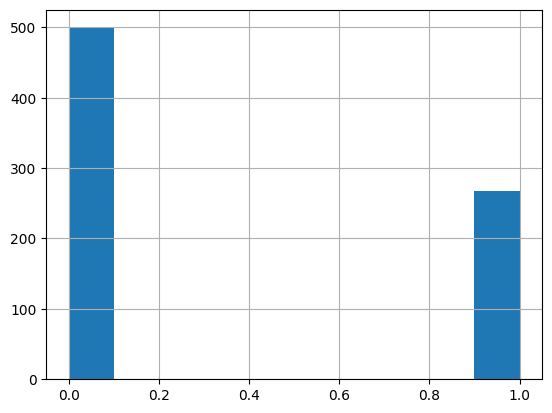

In [290]:
data['Outcome'].hist()
plt.show()

Распределение норм, баланс классов хороший

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [291]:
y = data['Outcome']
X = data.drop('Outcome', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

---
По описанию задания очень похоже, что нужно использовать `GridSearchCV`. Сначала попытался использовать его, но понял, что там же кросс-валидация (дада, название класса ни о чем не говорит). А выставить параметр `cv=1` нельзя :((. Искал как можно не делать сплита и подбирать параметр по готовой выборке, но кроме супер костылей ничего не нашел

Поэтому решил написать свой мини-GridSearch. Название говорит само за себя

In [292]:
def ShitGridSearch(estimator, 
                   params: Dict,
                   score_func: Callable, 
                   X_train, X_test, y_train, y_test):
    
    n1, n2 = params.keys()

    res = pd.DataFrame(columns=[f'{n1} = {p1}' for p1 in params[n1]], 
                   index=[f'{n2} = {p2}' for p2 in params[n2]], 
                   dtype=float)
    
    for p1 in params[n1]:
        for p2 in params[n2]:

            est = estimator(**{n1: p1, n2: p2}, random_state=42)
            est.fit(X_train, y_train)

            pred = est.predict(X_test)
            res[f'{n1} = {p1}'][f'{n2} = {p2}'] = round(score_func(y_test, pred), 3)


    display(res)

In [293]:
params = {'max_depth':[2, 4, 6, 8, 10], 'min_samples_leaf': [1, 4, 8, 12, 16]}

ShitGridSearch(DecisionTreeClassifier, params, f1_score, 
               X_train_train, X_train_val, 
               y_train_train, y_train_val)

,max_depth = 2,max_depth = 4,max_depth = 6,max_depth = 8,max_depth = 10
min_samples_leaf = 1,0.425,0.606,0.630,0.600,0.622
min_samples_leaf = 4,0.444,0.617,0.587,0.558,0.590
min_samples_leaf = 8,0.444,0.624,0.655,0.648,0.566
min_samples_leaf = 12,0.444,0.624,0.648,0.614,0.614
min_samples_leaf = 16,0.444,0.624,0.562,0.562,0.562


Видим, что наилучший показательн при `max_depth = 6` и `min_samples_leaf = 8`

Для вывода метрик напишем свой аналог `classification_report_`

In [294]:
def show_scores(y_true, y_pred):
    print(f'Accuracy = {round(accuracy_score(y_true, y_pred), 4)}')
    print(f'Precision = {round(precision_score(y_true, y_pred), 4)}')
    print(f'Recall = {round(recall_score(y_true, y_pred), 4)}')
    print(f'AUC-ROC = {round(roc_auc_score(y_true, y_pred), 4)}')

Теперь посмотрим на метрики при "оптимальных" параметрах

In [295]:
dt_optimized = DecisionTreeClassifier(max_depth=6, min_samples_leaf=8, random_state=42)

pred = dt_optimized.fit(X_train, y_train).predict(X_test)

show_scores(y_test, pred)

Accuracy = 0.6797
Precision = 0.5288
Recall = 0.6875
AUC-ROC = 0.6815


Ну чето как-то грустно. Наверное одного дерева маловато

**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [296]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(max_depth=6, min_samples_leaf=8), n_estimators=50,
                            random_state=42, n_jobs=4)

bag_clf.fit(X_train, y_train);

In [297]:
pred = bag_clf.predict(X_test)
show_scores(y_test, pred)

Accuracy = 0.7532
Precision = 0.6386
Recall = 0.6625
AUC-ROC = 0.7319


Уже сильно получше, все метрики значительно подросли. Наглядно видно преимущество использования композиции деревьев

**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

---
Ну вот тут точно нужно юзать `GridSearchCV`, писать еще один свой аналог, поддерживающий кросс валидацию я не хочу

Параметр CV оставил стандартным (по документации - 5)

In [298]:
from sklearn.model_selection import GridSearchCV

params={'max_depth': [2, 4, 6, 8, 10], 'min_samples_split': [1, 4, 8, 12, 16]}

grid = GridSearchCV(RandomForestClassifier(50, random_state=42), 
                    params, 
                    scoring='f1',
                    n_jobs=4)

grid.fit(X_train, y_train);

In [299]:
grid.best_estimator_

RandomForestClassifier(max_depth=10, min_samples_split=12, n_estimators=50,
                       random_state=42)

Видим оптимальные параметры для `RandomForest` выше.

Модель и так уже обучалась на полной обучающей выборке, поэтому нужно только сделать предикт

In [300]:
pred = grid.best_estimator_.predict(X_test)

show_scores(y_test, pred)

Accuracy = 0.7446
Precision = 0.6296
Recall = 0.6375
AUC-ROC = 0.7194


Странно, но качество немного хуже, по сравнению с `BaggingClassifier`, но все еще сильно лучше одного `DecisionTreeClassifier`

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

In [301]:
roc_aucs = []
n_estimators = np.arange(1, 2000, 50)

for n in n_estimators:
    clf = RandomForestClassifier(n, max_depth=10, min_samples_split=12, 
                                 random_state=42, n_jobs=4)
    pred = clf.fit(X_train, y_train).predict(X_test)
    roc_aucs.append(roc_auc_score(y_test, pred))

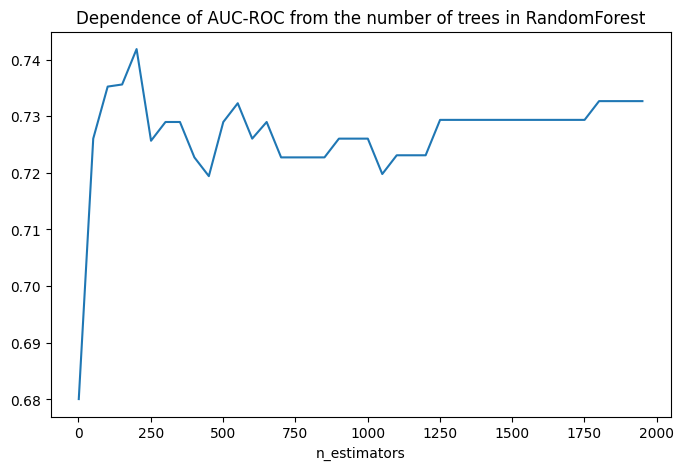

In [302]:
plt.figure(figsize=(8, 5))
plt.title('Dependence of AUC-ROC from the number of trees in RandomForest')

plt.plot(n_estimators, roc_aucs)
plt.xlabel('n_estimators')
# plt.ylim((0.5, 1))

plt.show()

Изначально AUC ROC колеблется, но при большом числе деревьев выходит на плато. Это связано с главной фичей RandomForest - отсутствием переобучения

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

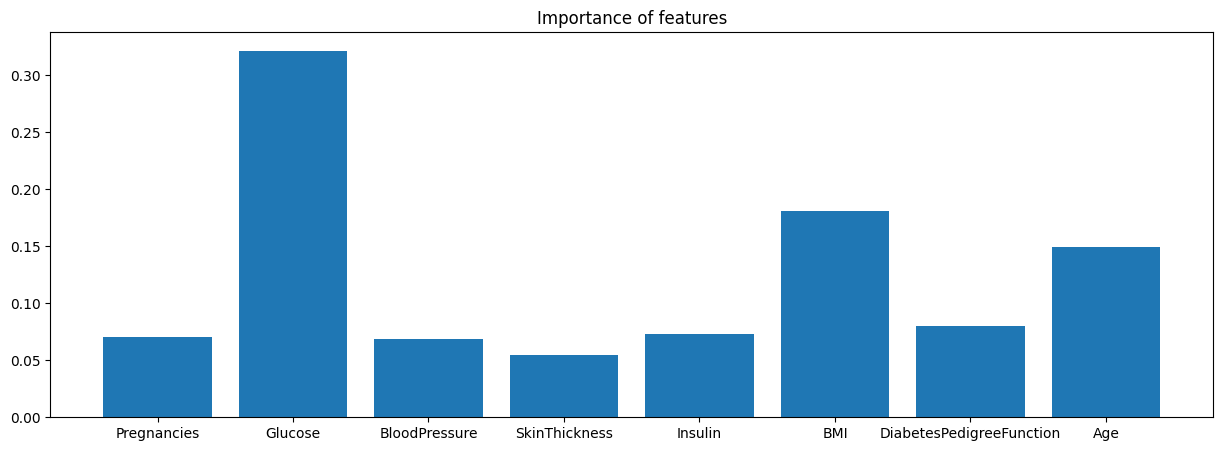

In [303]:
plt.figure(figsize=(15, 5))
plt.title('Importance of features')

plt.bar(X_train.columns, grid.best_estimator_.feature_importances_)

plt.show()

Видим, что самым важным признаком оказалось содержание сахара в крови (`Glucose`). Оно и понятно, это самый главный признак сахарного диабета

Также достаточно важными оказались индекс рост-вес (`BMI`). Он характеризует телосложение человека. Интуитивно это также понятно, потому что у людей с лишним весом риск диабета повышен

Еще важным окащался признак - возраст, потому что чаще всего диабет встречается именно у старшего поколения